# Image classification

In this notebook you will learn how to use two well known image classification techniques, the bag of words algorithm as well as the convolutional neural networks.

Requirements:
- Python 3
- opencv-python (4.6.0)
- scikit-learn (1.2.0)


## The problem

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60000 examples and a test set of 10000 examples. Both datasets are saved in a csv file where each line contains a label and the intensity values of a 28x28 grayscale image that depicts a piece of clothing. This dataset contains only objects of 10 classes.

The following function reads the contents of one of this csv files:

In [6]:
import numpy as np
import csv
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [7]:
# Load a csv file of the fashion MNIST dataset
# - filename: path filename of the csv file
# Returns the list of images and the list of corresponding labels

def load_mnist_dataset(filename):
    f = open(filename, 'r')
    reader = csv.reader(f, delimiter=',')
    data = []
    images = []
    labels = []
    next(reader)
    for row in reader:
        labels.append(int(row[0]))
        images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
    f.close()
    return images, labels


We can use the previous function to read and display some images of both datasets (it can take a while):

In [8]:
train_images, train_labels = load_mnist_dataset("res/fashion-mnist_train.csv")
test_images, test_labels =  load_mnist_dataset("res/fashion-mnist_test.csv")


#Use just the first 10% of the datasets
num_train_samples = int(len(train_images) * 0.2)
num_test_samples = int(len(test_images) )

train_images_1 = train_images[:num_train_samples]
train_labels_1 = train_labels[:num_train_samples]

test_images_1 = test_images[:num_test_samples]
test_labels_1 = test_labels[:num_test_samples]

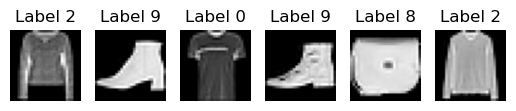

In [9]:
n_samples = 6

f, ax = plt.subplots(1,n_samples)
for i in range(n_samples):
    idx = np.random.randint(0, high=len(train_images))
    ax[i].imshow(train_images[idx], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Label {train_labels[idx]}')
plt.show()

In this notebook you will develop a methodology to classify an input image into its corresponding label.

## Bag of words
The first approach will use the Bag of Words algorithm. This algorithm consists of the following steps:

1. Given a set of descriptors computed from the training images, define a vocabulary of visual words.
2. For each image in the training dataset
    1. Compute its descriptors
    2. Assign each descriptor to the closest word in the vocabulary
    3. Build a histogram of words
3. Use the histograms and the labels of each image in the training dataset to train a classifier 
4. Save both the vocabulary and trained classifier

For inference, follow the next steps:
1. Compute the descriptors of the input image
2. Assign each descriptor to the closest word in the saved vocabulary
3. Build the histogram
4. Use the trained classifier to obtain the label of the input image

### Step 1: Define a vocabulary of visual words


In order to build the vocabulary, the first step is to describe the input image using keypoints and its descriptors. To this end, you should use an efficient and robust algorithm, for example, SIFT. 



In [10]:
detector = cv.SIFT_create()

The second step is computing descriptors of images in training dataset and cluster all the gathered descriptors using a clustering algorithm, e.g. KMeans. The number of cluser centers defines the size of the vocabulary. The class `cv.BOWKMeansTrainer` helps with these tasks:

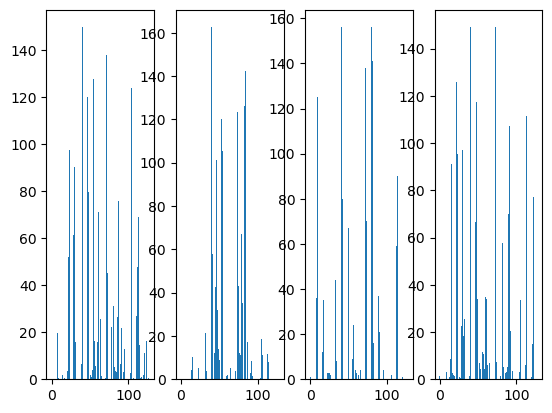

In [11]:
voc_size = 4 # Size of the vocabulary (toy example)

bow_trainer = cv.BOWKMeansTrainer(voc_size)

# Compute the descriptors of a image and add them to the bow trainer
image = train_images[0]
keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
if descriptors is not None:
    bow_trainer.add(descriptors)

# Cluster the descriptors, this is, get the vocabulary
vocabulary = bow_trainer.cluster() 
f, ax = plt.subplots(1, voc_size)
for idx, word in enumerate(vocabulary):
    ax[idx].bar(range(0, word.shape[0]), word)
plt.show()

#### Exercise
Implement the following function that computes the vocabulary from the images in the training set.

**Note**: the number of descriptors in the training dataset (60000 images) is near 250k. In order to speed up the computation of the vocabulary, select only a random set of images of each class (10-20%).


In [12]:
def get_vocabulary(voc_size, images, labels, detector, output_filename):
    bow_trainer = cv.BOWKMeansTrainer(voc_size)

    # Loop over all images and extract their descriptors
    for image in images:
        keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
        if descriptors is not None:
            bow_trainer.add(descriptors)

    # Cluster the descriptors to obtain the visual vocabulary
    vocabulary = bow_trainer.cluster()

    # Save the vocabulary to a file
    np.save(output_filename, vocabulary)

    # Return the vocabulary
    return vocabulary

#### Exercise
Compute and save vocabularies of three suitable sizes


In [13]:
# vocabulary size 1 
### Write your code here

voc_size= 72
detector = cv.SIFT_create()
output_filename = os.path.join( "vocabulary1")

get_vocabulary(voc_size, train_images_1, train_labels_1, detector, output_filename)

array([[9.2709923e+00, 4.3492365e+00, 5.0229006e+00, ..., 1.0452291e+01,
        6.1335878e+00, 5.7576337e+00],
       [1.8709677e+00, 7.0118845e-01, 3.4465197e-01, ..., 2.5263159e+00,
        3.3904924e+00, 4.6095076e+00],
       [2.2252747e-01, 4.7619049e-02, 0.0000000e+00, ..., 5.5860806e-02,
        1.4652015e-02, 2.7472528e-03],
       ...,
       [2.2836336e+01, 7.6711712e+00, 2.4939940e+00, ..., 1.5630631e+01,
        1.8375376e+01, 1.7717718e+01],
       [2.0509848e+01, 1.9991247e+01, 2.1989059e+01, ..., 5.1772428e+00,
        5.4923415e-01, 8.5776806e-01],
       [3.8147173e+00, 1.9960577e+00, 7.7135348e-01, ..., 8.9434948e+00,
        7.8134031e+00, 5.2444153e+00]], dtype=float32)

In [14]:
# vocabulary size 2
### Write your code here

voc_size= 200
detector = cv.SIFT_create()
output_filename = os.path.join( "vocabulary2")

get_vocabulary(voc_size, train_images_1, train_labels_1, detector, output_filename)

array([[1.94821429e+00, 5.35714291e-02, 0.00000000e+00, ...,
        1.33928567e-01, 0.00000000e+00, 0.00000000e+00],
       [2.80357151e+01, 7.89285707e+00, 3.99285722e+00, ...,
        1.87428570e+01, 6.44714279e+01, 2.35285721e+01],
       [1.45421243e+00, 1.24542125e-01, 3.66300368e-03, ...,
        5.49084234e+00, 6.55677652e+00, 4.80219793e+00],
       ...,
       [3.66971169e+01, 6.17836571e+01, 2.07115383e+01, ...,
        8.65384638e-01, 2.98076928e-01, 3.60576928e-01],
       [1.04418602e+01, 4.28372078e+01, 1.17709305e+02, ...,
        8.13953459e-01, 2.67441869e-01, 1.16279069e-02],
       [3.64117646e+00, 4.70000029e+00, 3.38235307e+00, ...,
        6.91647110e+01, 1.36823530e+01, 2.80588245e+00]], dtype=float32)

In [15]:
# vocabulary size 3
### Write your code here


voc_size= 512
detector = cv.SIFT_create()
output_filename = os.path.join("vocabulary3")

get_vocabulary(voc_size, train_images_1, train_labels_1, detector, output_filename)

array([[2.9288889e+01, 9.1999998e+00, 5.3555555e+00, ..., 2.5355556e+01,
        2.3266666e+01, 1.4355556e+01],
       [2.5781250e+00, 6.4062500e-01, 1.0625000e+00, ..., 5.8125000e+00,
        2.4375000e+00, 1.7968750e+00],
       [6.1226416e+00, 1.2328302e+02, 1.0879246e+02, ..., 9.4339624e-03,
        1.8867925e-02, 0.0000000e+00],
       ...,
       [2.7068965e+00, 2.4137931e-01, 1.2068965e-01, ..., 7.9137931e+00,
        7.6724138e+00, 5.4137931e+00],
       [3.8297871e-01, 6.3829787e-02, 0.0000000e+00, ..., 2.5000000e+00,
        9.1489357e-01, 8.5106379e-01],
       [3.0000000e+00, 2.8571430e-01, 2.8571431e-02, ..., 3.5600002e+01,
        2.9333334e+00, 1.4190477e+00]], dtype=float32)

### Step 2: Build histograms from the training dataset

The class `cv.BOWImgDescriptorExtractor` simplifies this operation. The constructor of this class needs two parameters: a keypoint detector and descriptor as well as an algorithm to match the descriptors to the cluster centers of the vocabulary. In our case, we use a brute force matcher and the SIFT detector that we have defined previously.

In [16]:
matcher = cv.BFMatcher(cv.NORM_L2)
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)

We have to init this class with a previously defined vocabulary.

In [17]:
bow_extractor.setVocabulary(vocabulary) # toy example

After that, we can compute the histogram of a given image as follows:

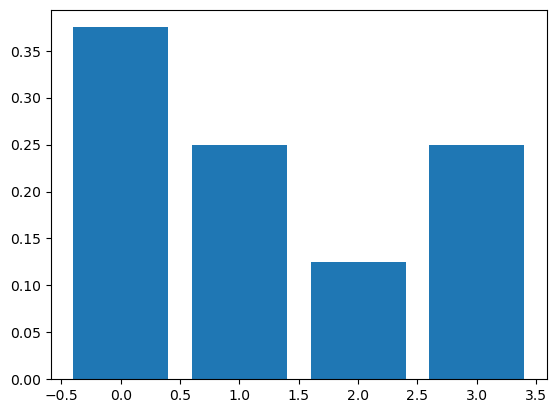

In [18]:
keypoints = detector.detect(train_images[0])
histograms = bow_extractor.compute(train_images[0], keypoints)
plt.bar(range(histograms[0].shape[0]), histograms[0])
plt.show()

Be careful, the output histogram is `None` when all its values are 0.

#### Exercise
Implement a function that computes the histograms of a set of images. If the `bow_extractor` returns `None` when computing the histogram, replace this value by an array of 0s.  

In [19]:
def get_histograms(bow_extractor, images, vocabulary_size):
    histograms = []
    
    # Loop over all images and compute their histograms
    for image in images:
        # Detect keypoints and compute the histogram
        keypoints = detector.detect(image)
        histogram = bow_extractor.compute(image, keypoints)
        
        # If the histogram is None, append an array of zeros
        if histogram is None:
            histogram = np.zeros((1, vocabulary_size))
        
        # Append the histogram to the list
        histograms.append(histogram[0])

    # Convert the list of histograms to a NumPy array
    histograms = np.array(histograms)

    return histograms

### Step 3: Train a classifier
Use the histograms and the labels to train a classifier [(SVM, Random Forest, KNN, ...)](https://scikit-learn.org/stable/supervised_learning.html). Compute the success rate after training in the training set by comparing the classifier outputs with the actual labels as well as the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

Repeat the procedure with the other two vocabularies that you have built.

**Important**: do not forget to set the appropriate vocabulary to the `bow_extractor`before computing the histograms

**Note**: if you use SVM, apply a grid search in order to find the best parameters.




In [20]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

def train_svm(histograms, labels):
    # Set parameter grid for grid search
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

    # Initialize SVM classifier
    clf = svm.SVC(decision_function_shape='ovr')

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf, param_grid=param_grid)
    grid_search.fit(histograms, labels)

    # Train the classifier with best parameters
    clf = grid_search.best_estimator_
    clf.fit(histograms, labels)

    # Get predicted labels
    predicted_labels = clf.predict(histograms)

    # Compute accuracy and confusion matrix
    accuracy = accuracy_score(labels, predicted_labels)
    confusion = confusion_matrix(labels, predicted_labels)

    return clf, accuracy, confusion

In [21]:
# vocabulary size 1
### Write your code here

images = train_images_1
matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 72

# Load the vocabulary from the file
vocabulary = np.load("vocabulary1.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histograms1 = get_histograms(bow_extractor, images, vocabulary_size)


In [22]:
# Train the classifier
clf1, accuracy, confusion = train_svm(histograms1, train_labels_1)

Accuracy: 0.6439166666666667


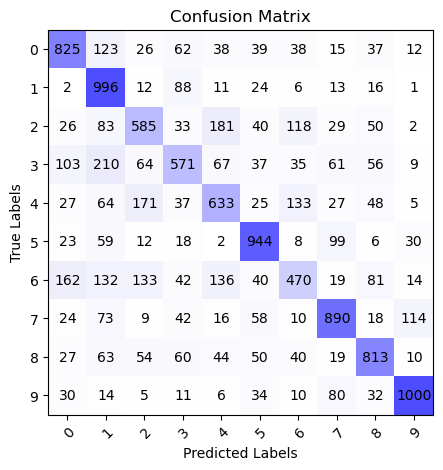

In [23]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

print("Accuracy:", accuracy)

fig, ax = plt.subplots(figsize=(5, 5))
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#FFFFFF'), (0.25, '#E6E6FA'), (0.5, '#CCCCFF'), (0.75, '#9999FF'), (1, '#4D4DFF')])
ax.imshow(confusion, cmap=cmap, extent=(-0.5, 9.5, 9.5, -0.5))
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

for i in range(10):
    for j in range(10):
        ax.text(j, i, confusion[i, j], ha='center', va='center', color='black')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [24]:
# vocabulary size 2
### Write your code here

images = train_images_1
matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 200

# Load the vocabulary from the file
vocabulary = np.load("vocabulary2.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histograms2 = get_histograms(bow_extractor, images, vocabulary_size)


In [25]:
# Train the classifier
clf2, accuracy, confusion = train_svm(histograms2, train_labels_1)

Accuracy: 0.7305


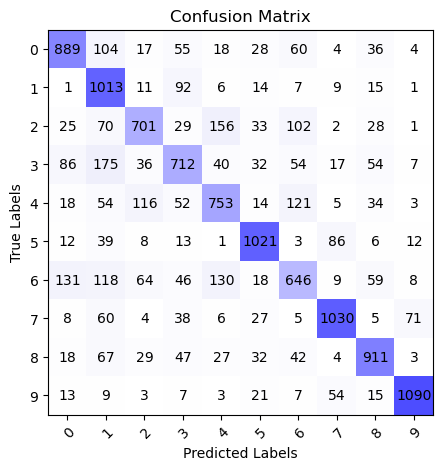

In [26]:
print("Accuracy:", accuracy)

fig, ax = plt.subplots(figsize=(5, 5))
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#FFFFFF'), (0.25, '#E6E6FA'), (0.5, '#CCCCFF'), (0.75, '#9999FF'), (1, '#4D4DFF')])
ax.imshow(confusion, cmap=cmap, extent=(-0.5, 9.5, 9.5, -0.5))
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

for i in range(10):
    for j in range(10):
        ax.text(j, i, confusion[i, j], ha='center', va='center', color='black')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [27]:
# vocabulary size 3
### Write your code here


matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 512

# Load the vocabulary from the file
vocabulary = np.load("vocabulary3.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histograms3 = get_histograms(bow_extractor, images, vocabulary_size)

In [28]:
# Train the classifier
clf3, accuracy, confusion = train_svm(histograms3, train_labels_1)

Accuracy: 0.7893333333333333


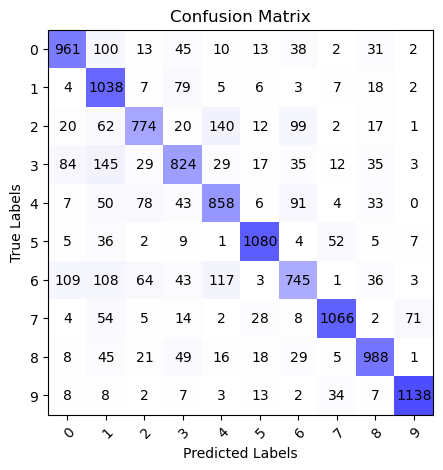

In [29]:
print("Accuracy:", accuracy)

fig, ax = plt.subplots(figsize=(5, 5))
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#FFFFFF'), (0.25, '#E6E6FA'), (0.5, '#CCCCFF'), (0.75, '#9999FF'), (1, '#4D4DFF')])
ax.imshow(confusion, cmap=cmap, extent=(-0.5, 9.5, 9.5, -0.5))
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

for i in range(10):
    for j in range(10):
        ax.text(j, i, confusion[i, j], ha='center', va='center', color='black')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Step 4: Test the classifier

Test the classifier with the test dataset, compute the success rate and the confussion matrix.

In [37]:
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score, confusion_matrix

def test_classifier(classifier, test_histograms, test_labels):
    # Predict labels for the test histograms
    predicted_labels = classifier.predict(test_histograms)

    # Compute the success rate
    success_rate = accuracy_score(test_labels, predicted_labels)

    # Compute the confusion matrix
    confusion_matrix = metrics.confusion_matrix(test_labels, predicted_labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#FFFFFF'), (0.25, '#E6E6FA'), (0.5, '#CCCCFF'), (0.75, '#9999FF'), (1, '#4D4DFF')])
    ax.imshow(confusion_matrix, cmap=cmap, extent=(-0.5, 9.5, 9.5, -0.5))
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

    for i in range(10):
        for j in range(10):
            ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

    return success_rate

In [39]:
### Write your code here
# First of all I need the vocabulary of the test set

voc_size= 200
detector = cv.SIFT_create()
output_filename = os.path.join( "vocabularytest")

get_vocabulary(voc_size, test_images_1, test_labels_1, detector, output_filename)

# Then I need the histograms
images = test_images_1
matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 200

# Load the vocabulary from the file
vocabulary = np.load("vocabularytest.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histogramstest = get_histograms(bow_extractor, images, vocabulary_size)

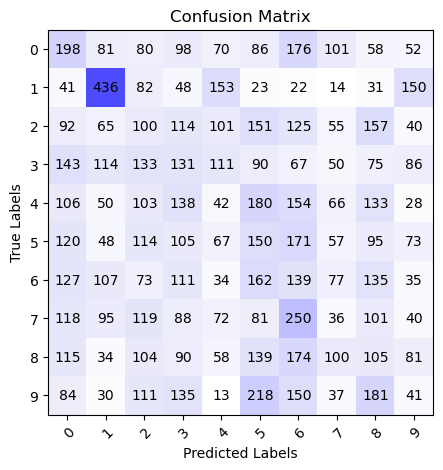

0.1378

In [40]:
classifier = clf2
test_histograms = histogramstest
test_labels = test_labels_1


test_classifier(classifier, test_histograms, test_labels)

In [41]:
voc_size= 72
detector = cv.SIFT_create()
output_filename = os.path.join( "vocabularytest")

get_vocabulary(voc_size, test_images_1, test_labels_1, detector, output_filename)

# Then I need the histograms
images = test_images_1
matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 72

# Load the vocabulary from the file
vocabulary = np.load("vocabularytest.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histogramstest = get_histograms(bow_extractor, images, vocabulary_size)

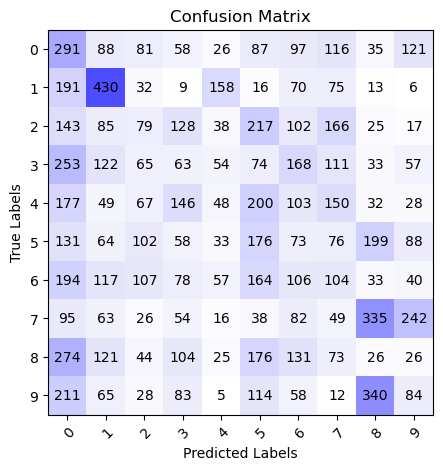

0.1352

In [42]:
classifier = clf1
test_histograms = histogramstest
test_labels = test_labels_1


test_classifier(classifier, test_histograms, test_labels)

In [43]:
voc_size= 512
detector = cv.SIFT_create()
output_filename = os.path.join( "vocabularytest")

get_vocabulary(voc_size, test_images_1, test_labels_1, detector, output_filename)

# Then I need the histograms
images = test_images_1
matcher = cv.BFMatcher(cv.NORM_L2)
detector = cv.SIFT_create()
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)
vocabulary_size = 512

# Load the vocabulary from the file
vocabulary = np.load("vocabularytest.npy")
bow_extractor.setVocabulary(vocabulary)

# Compute the histograms
histogramstest = get_histograms(bow_extractor, images, vocabulary_size)

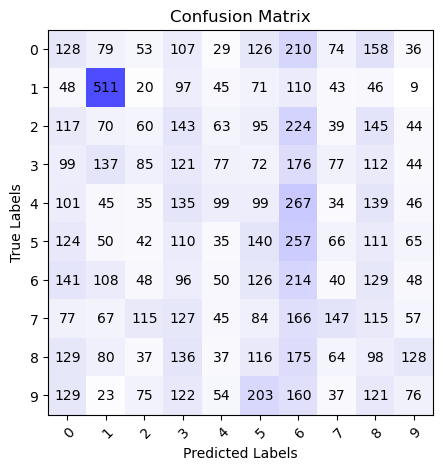

0.1594

In [44]:
classifier = clf3
test_histograms = histogramstest
test_labels = test_labels_1


test_classifier(classifier, test_histograms, test_labels)